<a href="https://colab.research.google.com/github/SumeyyeSuslu/ES6-JavaScript-video/blob/master/DarkCovidNet_model_for_three_classes_100replay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fb8a64ee-fc67-4e32-87e7-efeb5fdc93d4)


In [2]:
#! git clone https://github.com/muhammedtalo/COVID-19.git

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from fastai.vision import *
import torch.nn.functional as F



In [6]:

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
    
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)

### Data

In [7]:
path = Path('/content/COVID-19/X-Ray Image DataSet')

In [8]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, valid_pct =0.2,
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [10]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 900
Number of examples in validation: 225


In [11]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

---

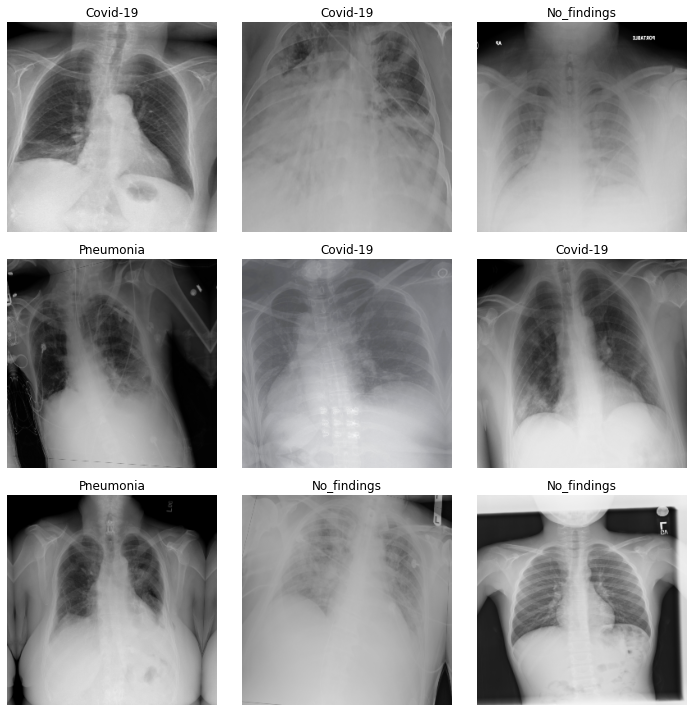

In [12]:
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [13]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [14]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [15]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [16]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [17]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [18]:
learn.load('/content/learn100')

Learner(data=ImageDataBunch;

Train: LabelList (900 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
No_findings,No_findings,No_findings,No_findings,No_findings
Path: /content/COVID-19/X-Ray Image DataSet;

Valid: LabelList (225 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Pneumonia,Pneumonia,Pneumonia,No_findings,Pneumonia
Path: /content/COVID-19/X-Ray Image DataSet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [19]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [20]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [21]:
accuracy(probs,targets)

tensor(0.8711)

In [22]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [23]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 196 0.8711111111111111
[[26  2  2]
 [ 0 88  2]
 [ 0 23 82]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.87      0.93        30
 No_findings       0.78      0.98      0.87        90
   Pneumonia       0.95      0.78      0.86       105

    accuracy                           0.87       225
   macro avg       0.91      0.88      0.88       225
weighted avg       0.89      0.87      0.87       225



In [24]:
interp = ClassificationInterpretation.from_learner(learn)

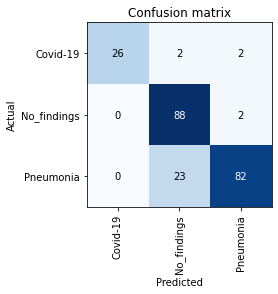

In [25]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);